In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import torch_harmonics as th
import torch
import numpy as np
import matplotlib as mpl
from datetime import datetime, timedelta
import cartopy.crs as ccrs

In [2]:
import xarray as xr
import glob

DATES = [
    "2020-01-06T00:00:00",
    "2020-01-13T00:00:00",
    "2020-01-20T00:00:00",
    "2020-01-27T00:00:00",
    "2020-02-03T00:00:00",
    "2020-02-10T00:00:00",
    "2020-02-17T00:00:00",
    "2020-02-24T00:00:00",
    "2020-03-02T00:00:00",
    "2020-03-09T00:00:00",
    "2020-03-16T00:00:00",
    "2020-03-23T00:00:00",
    "2020-03-30T00:00:00",
    "2020-04-06T00:00:00",
    "2020-04-13T00:00:00",
    "2020-04-20T00:00:00",
    "2020-04-27T00:00:00",
    "2020-05-04T00:00:00",
    "2020-05-11T00:00:00",
    "2020-05-18T00:00:00",
    "2020-05-25T00:00:00",
    "2020-06-01T00:00:00",
    "2020-06-08T00:00:00",
    "2020-06-15T00:00:00",
    "2020-06-22T00:00:00",
    "2020-06-29T00:00:00",
    "2020-07-06T00:00:00",
    "2020-07-13T00:00:00",
    "2020-07-20T00:00:00",
    "2020-07-27T00:00:00",
    "2020-08-03T00:00:00",
    "2020-08-10T00:00:00",
    "2020-08-17T00:00:00",
    "2020-08-24T00:00:00",
    "2020-08-31T00:00:00",
    "2020-09-07T00:00:00",
    "2020-09-14T00:00:00",
    "2020-09-21T00:00:00",
    "2020-09-28T00:00:00",
    "2020-10-05T00:00:00",
    "2020-10-12T00:00:00",
    "2020-10-19T00:00:00",
    "2020-10-26T00:00:00",
    "2020-11-02T00:00:00",
    "2020-11-09T00:00:00",
    "2020-11-16T00:00:00",
    "2020-11-23T00:00:00",
    "2020-11-30T00:00:00",
    "2020-12-14T00:00:00",]

def load_files(metric):
    # Define the base path
    base_path = "/pscratch/sd/a/amahesh/hens/time_collection/bred_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0_part2020/"
    
    subdirectories = [f"{base_path}/{date_str}" for date_str in DATES]

    # Initialize an empty list to store xarray datasets
    datasets = []

    # Iterate over each subdirectory
    for subdirectory in sorted(subdirectories):
        # Construct the full path to ensemble_mse.zarr within each subdirectory
        file_path = subdirectory + f"/{metric}.zarr"
        
        # Open the Zarr file as an xarray dataset
        dataset = xr.open_zarr(file_path, decode_times=False)
        # Append the dataset to the list of datasets
        datasets.append(dataset)

    # Concatenate all datasets along the time dimension
    return xr.concat(datasets, dim='initial_time')

sfno = load_files("ensemble")

In [3]:
ifs_zarr = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721_mean.zarr')
ifs_zarr = ifs_zarr.sel(time=DATES)
ifs_zarr = ifs_zarr.rename({'latitude' : 'lat',
                  'longitude' : 'lon'})

In [4]:
def calculate_spectrum(KE_500):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # calculate the spherical harmonic transform of KE_500
    ntime = len(KE_500.time)
    nlat = len(KE_500.lat)
    nlon = len(KE_500.lon)
    print(ntime)
    # initialize the scalar spherical harmonic transform
    sht = th.RealSHT(nlat, nlon, grid = "equiangular").to(device).float()

    # initialize the vector spherical harmonic transform
    #vsht = th.RealVectorSHT(nlat, nlon, grid = "equiangular").to(device).float()

    # initialize the spherical harmonic vector inverse transform
    #ivsht = th.InverseRealVectorSHT(nlat, nlon, grid = "equiangular").to(device).float()

    # calculate the SHT coefficients
    coeffs = sht(torch.from_numpy(KE_500.values).to(device))

    # normalize by Earth's surface area [m^2]
    r_earth = 6.371e6
    a_earth = 4*np.pi*r_earth**2
    
    # calculate the power spectrum
    # the SHT coefficient dimensions are (time, l, m)
    l_array = torch.arange(0, nlat, device = device)[None, :] * torch.ones(ntime, nlat, device = device)
    P_KE_500 = torch.real((2/(2*l_array + 1)) * torch.sum(coeffs * torch.conj(coeffs), dim = -1))

    l = np.arange(nlat)
    P_KE_500 = P_KE_500.numpy(force = True)

    # convert spherical harmonic degree to wavelength [km]
    lam = 2*np.pi*r_earth/(l + 1) / 1e3
    
    return lam, P_KE_500, ntime


49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49


<Figure size 1920x1440 with 0 Axes>

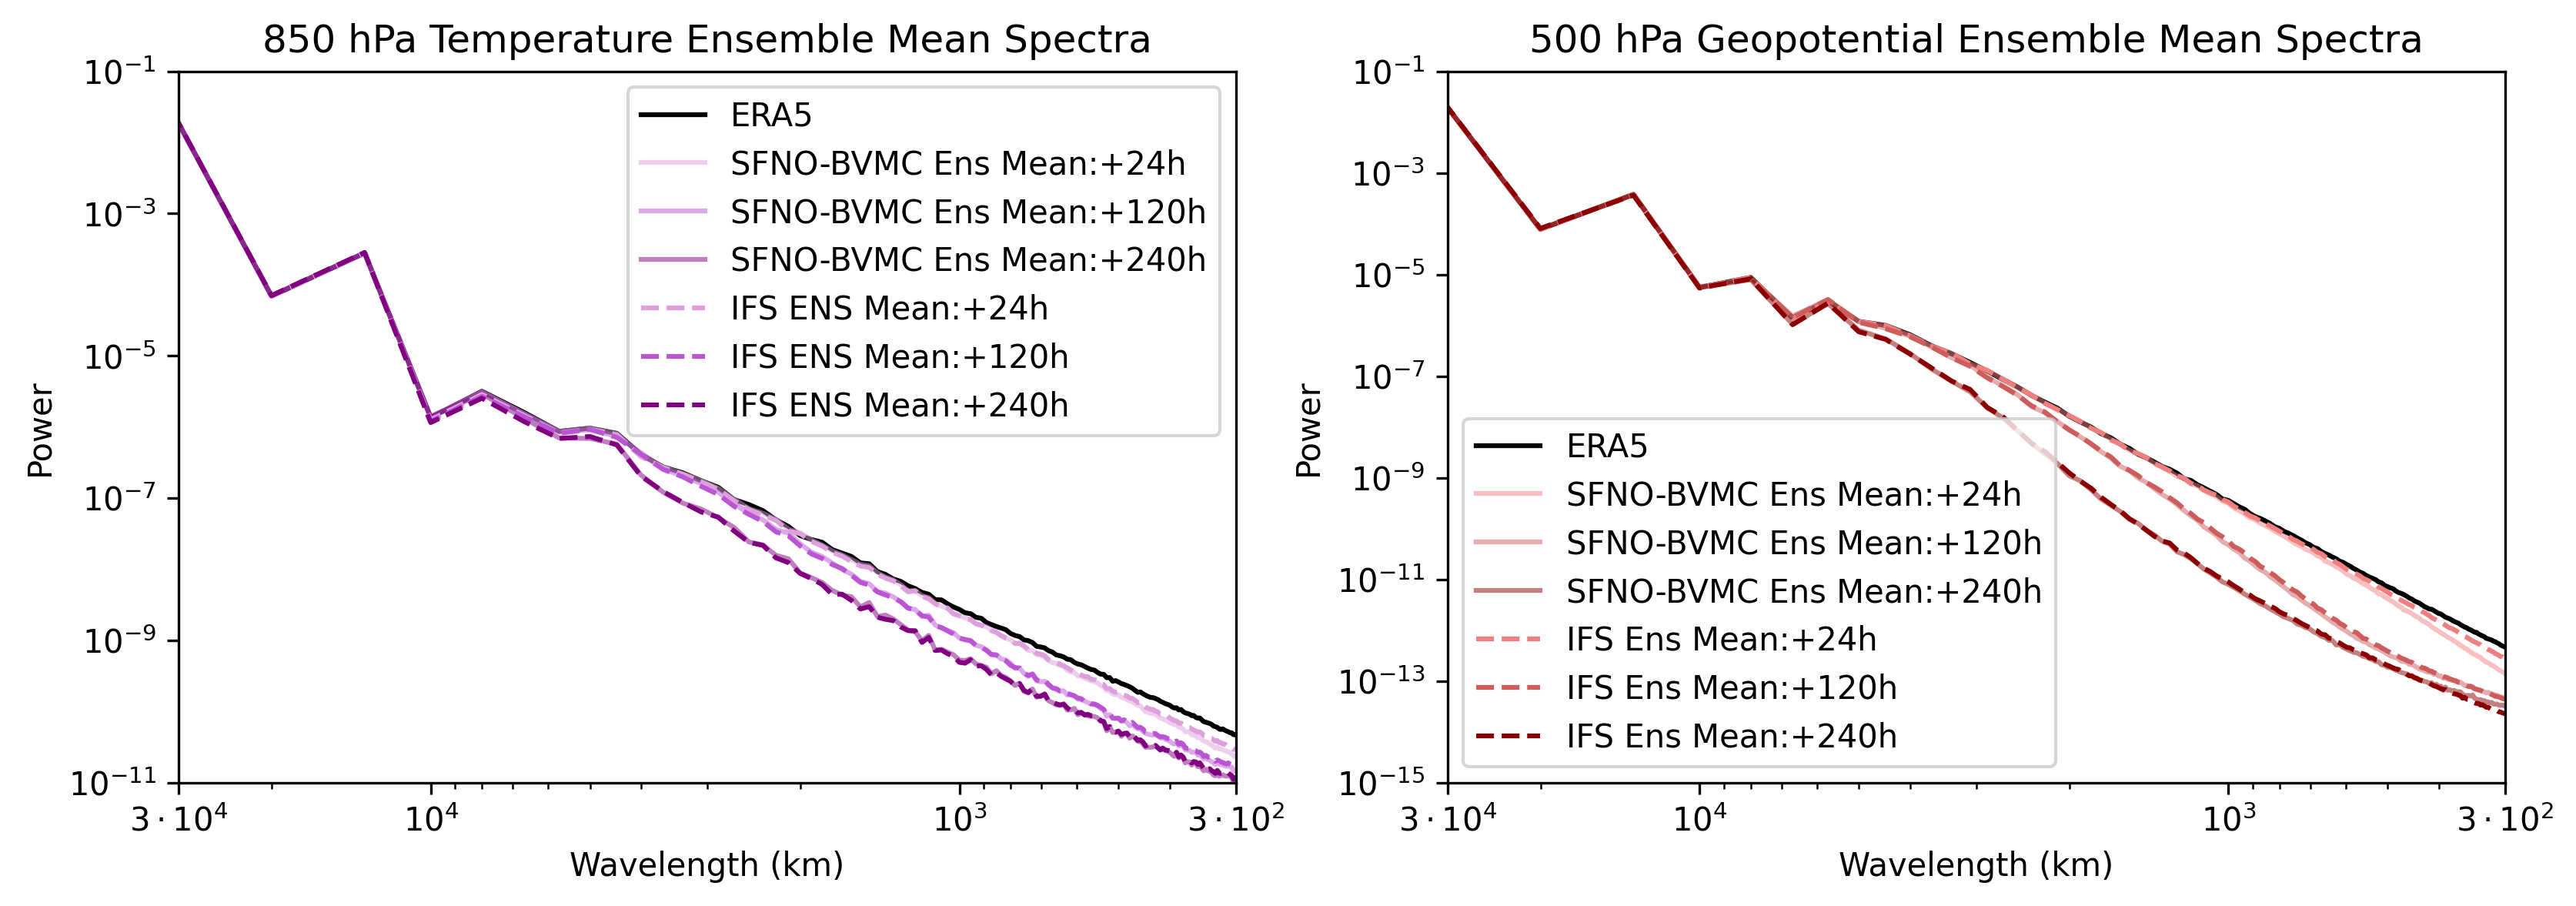

In [5]:
plt.figure(dpi=300)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4), dpi=300)


#Ensemble Mean Spectra
for var in ['t850']:
    ifs = ifs_zarr.sel(level=850)['temperature']
    lam_ifs, ifs_spectrum, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=4,drop=True))
    lam_ifs, ifs_spectrum_end, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=40,drop=True))
    lam_ifs, ifs_spectrum_20h, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=20,drop=True))
    lam_ifs, ifs_spectrum_12h, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=2,drop=True))
    lam_ifs, ifs_spectrum_6h, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=1,drop=True))
    
    
    
    lam_sfno, era5_spectrum, ntime = calculate_spectrum(sfno[var].isel(ensemble=0,time=0,drop=True).rename({
        'initial_time' : 'time'}))
    
    
    
    lam_sfno, sfno_spectrum, ntime = calculate_spectrum(sfno[var].isel(time=4,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}))
    lam_sfno, sfno_spectrum_end, ntime = calculate_spectrum(sfno[var].isel(time=40,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}).load())
    lam_sfno, sfno_spectrum_20h, ntime = calculate_spectrum(sfno[var].isel(time=20,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}).load())
    lam_sfno, sfno_spectrum_12h, ntime = calculate_spectrum(sfno[var].isel(time=2,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}).load())
    lam_sfno, sfno_spectrum_6h, ntime = calculate_spectrum(sfno[var].isel(time=2,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}).load())
ax = ax1
ax.plot(lam_sfno, (era5_spectrum / era5_spectrum[:, 0:1]).mean(0),
         label='ERA5', color='black')
ax.plot(lam_sfno, (sfno_spectrum / sfno_spectrum[:, 0:1]).mean(0),
         label='SFNO-BVMC Ens Mean:+24h', color='plum', alpha=0.5)
ax.plot(lam_sfno, (sfno_spectrum_20h / sfno_spectrum_end[:, 0:1]).mean(0), 
         label='SFNO-BVMC Ens Mean:+120h',  color='mediumorchid', alpha=0.5)
ax.plot(lam_sfno, (sfno_spectrum_end / sfno_spectrum_end[:, 0:1]).mean(0), 
         label='SFNO-BVMC Ens Mean:+240h',  color='purple', alpha=0.5)
ax.plot(lam_sfno, (ifs_spectrum / ifs_spectrum[:, 0:1]).mean(0), 
         label='IFS ENS Mean:+24h', linestyle='dashed', color='plum')
ax.plot(lam_sfno, (ifs_spectrum_20h / ifs_spectrum_end[:, 0:1]).mean(0), 
         label='IFS ENS Mean:+120h', linestyle='dashed' ,color='mediumorchid')
ax.plot(lam_sfno, (ifs_spectrum_end / ifs_spectrum_end[:, 0:1]).mean(0), 
         label='IFS ENS Mean:+240h', linestyle='dashed', color='purple')

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlim((3*10**4,3*10**2))
ax.set_xticks([3 * 10**4, 10**4, 10**3, 3 * 10**2],
           labels=['$3 \cdot 10^4$', '$10^4$', '$10^3$', '$3 \cdot 10^2$'])

ax.set_ylim((10**-11,10**-1))
ax.set_xlabel("Wavelength (km)")
ax.set_ylabel("Power")
ax.set_title("850 hPa Temperature Ensemble Mean Spectra")


#Ensemble Mean Spectra
for var in ['z500']:
    ifs = ifs_zarr.sel(level=500)['geopotential']
    lam_ifs, ifs_spectrum, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=4,drop=True))
    lam_ifs, ifs_spectrum_end, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=40,drop=True))
    lam_ifs, ifs_spectrum_20h, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=20,drop=True))
    lam_ifs, ifs_spectrum_12h, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=2,drop=True))
    lam_ifs, ifs_spectrum_6h, ntime = calculate_spectrum(ifs.isel(prediction_timedelta=1,drop=True))
    
    
    
    lam_sfno, era5_spectrum, ntime = calculate_spectrum(sfno[var].isel(ensemble=0,time=0,drop=True).rename({
        'initial_time' : 'time'}))
    
    
    
    lam_sfno, sfno_spectrum, ntime = calculate_spectrum(sfno[var].isel(time=4,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}))
    lam_sfno, sfno_spectrum_end, ntime = calculate_spectrum(sfno[var].isel(time=40,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}).load())
    lam_sfno, sfno_spectrum_20h, ntime = calculate_spectrum(sfno[var].isel(time=20,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}).load())
    lam_sfno, sfno_spectrum_12h, ntime = calculate_spectrum(sfno[var].isel(time=2,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}).load())
    lam_sfno, sfno_spectrum_6h, ntime = calculate_spectrum(sfno[var].isel(time=2,drop=True).mean('ensemble').rename({
        'initial_time' : 'time'}).load())
    

ax = ax2
ax.plot(lam_sfno, (era5_spectrum / era5_spectrum[:, 0:1]).mean(0),
         label='ERA5', color='black')
ax.plot(lam_sfno, (sfno_spectrum / sfno_spectrum[:, 0:1]).mean(0),
         label='SFNO-BVMC Ens Mean:+24h', color='lightcoral', alpha=0.5)
ax.plot(lam_sfno, (sfno_spectrum_20h / sfno_spectrum_end[:, 0:1]).mean(0), 
         label='SFNO-BVMC Ens Mean:+120h',  color='indianred', alpha=0.5)
ax.plot(lam_sfno, (sfno_spectrum_end / sfno_spectrum_end[:, 0:1]).mean(0), 
         label='SFNO-BVMC Ens Mean:+240h',  color='darkred', alpha=0.5)
ax.plot(lam_sfno, (ifs_spectrum / ifs_spectrum[:, 0:1]).mean(0), 
         label='IFS Ens Mean:+24h', linestyle='dashed', color='lightcoral')
ax.plot(lam_sfno, (ifs_spectrum_20h / ifs_spectrum_end[:, 0:1]).mean(0), 
         label='IFS Ens Mean:+120h', linestyle='dashed' ,color='indianred')
ax.plot(lam_sfno, (ifs_spectrum_end / ifs_spectrum_end[:, 0:1]).mean(0), 
         label='IFS Ens Mean:+240h', linestyle='dashed', color='darkred')

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlim((3*10**4,3*10**2))
ax.set_xticks([3 * 10**4, 10**4, 10**3, 3 * 10**2],
           labels=['$3 \cdot 10^4$', '$10^4$', '$10^3$', '$3 \cdot 10^2$'])
ax.set_title("500 hPa Geopotential Ensemble Mean Spectra")

ax.set_ylim((10**-15,10**-1))
ax.set_xlabel("Wavelength (km)")
ax.set_ylabel("Power")
plt.savefig("ensemble_mean.pdf")
plt.show()
